In [1]:
import uproot
import hist
import numpy as np
import mplhep as hep
import plt
import awkward as ak
import matplotlib

from sklearn.metrics import roc_curve

from tensorflow.keras.models import Model, Sequential, load_model
from qkeras.utils import load_qmodel
from copy import deepcopy

2024-02-05 09:47:42.063048: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 09:47:42.725167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 09:47:45.118099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
plt.style.use(hep.style.CMS)

In [3]:
fs = uproot.open('tuples_vbf.root')
fb = uproot.open('tuples_minbias.root')

In [4]:
trees = fs['ntuplePupSingle/tree']
# trees = fs['ntuplePFSingle/tree']
# treeb = fb['ntuplePupSingle/tree']

In [5]:
trees.keys()

['run',
 'lumi',
 'event',
 'event2',
 'gendr1',
 'genpt1',
 'geneta1',
 'genphi1',
 'genid1',
 'chargedIso',
 'decayId',
 'dxy',
 'eta',
 'fullIso',
 'm',
 'passLoose',
 'passTight',
 'phi',
 'pt',
 'z0',
 'm_inputs']

In [6]:
fs.keys()

['ntuplePFSingle;1',
 'ntuplePFSingle/tree;1',
 'ntuplePupSingle;1',
 'ntuplePupSingle/tree;1',
 'ntuplePupDiTau;1',
 'ntuplePupDiTau/tree;1']

In [7]:
ar = trees.arrays()

In [8]:
model = load_qmodel("quantized_merged_pruned_gamma30.h5")
pred = model.predict(ar['m_inputs'].to_numpy())

2024-02-05 09:47:55.424069: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (100)


4834/4834 [==============================] - 16s 3ms/step


In [9]:
pred[0]

array([[0.724645  ],
       [0.5324413 ],
       [0.54458946],
       ...,
       [0.31081283],
       [0.7257405 ],
       [0.5187376 ]], dtype=float32)

In [10]:
ar = ak.with_field(ar, pred[0], where='NNTF')
ar = ak.with_field(ar, pred[1], where='nnptmult')

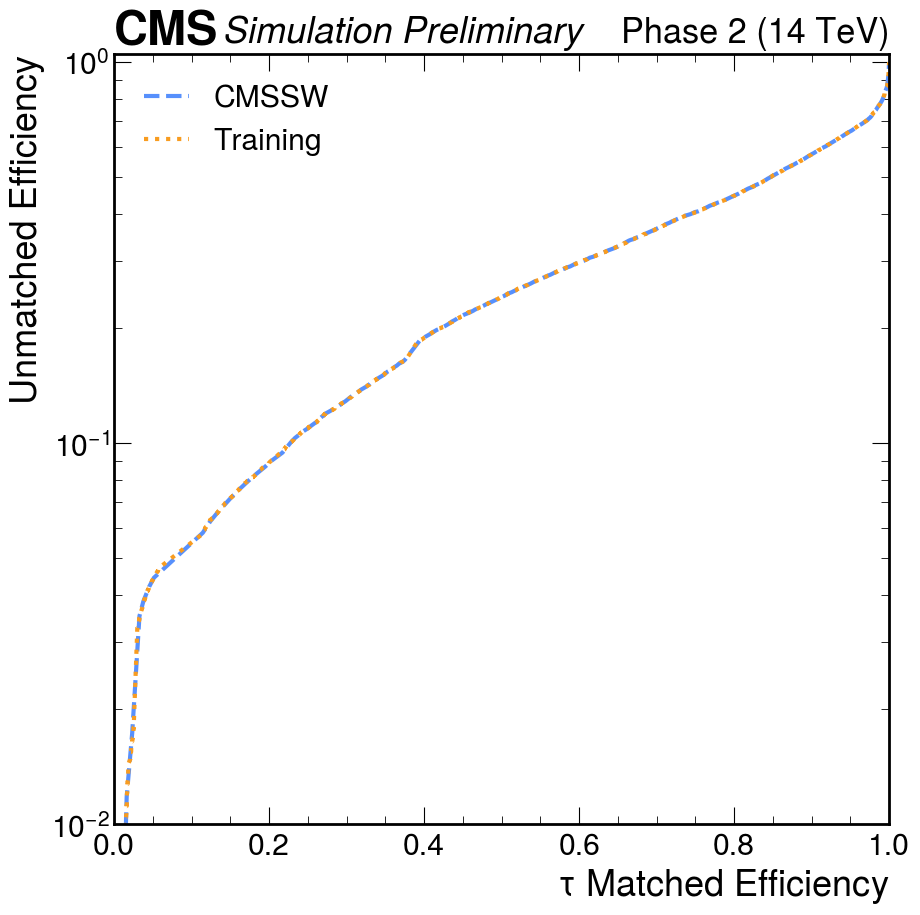

In [11]:
# ar = trees.arrays()
mask = (abs(ar['eta']) < 2.1) & (abs(ar['pt']) > 20) & (ar['decayId'] != 0) #& (ar['gendr1'] < 0.4) 
ar = ar[mask]
nnscore = ar['chargedIso']
tau_truth = ar['genpt1'] > 1

fpr, tpr, th = roc_curve(tau_truth, nnscore)
plt.plot(tpr, fpr, label="CMSSW", ls="--", lw=3);

fpr, tpr, th = roc_curve(tau_truth, ar['NNTF'])
plt.plot(tpr, fpr, label="Training", ls=":", lw=3);

hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")
plt.xlabel(r"$\tau$ Matched Efficiency")
plt.ylabel("Unmatched Efficiency")
plt.ylim(1e-2,None) 
plt.xlim(0,1)
plt.semilogy()
plt.legend()

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

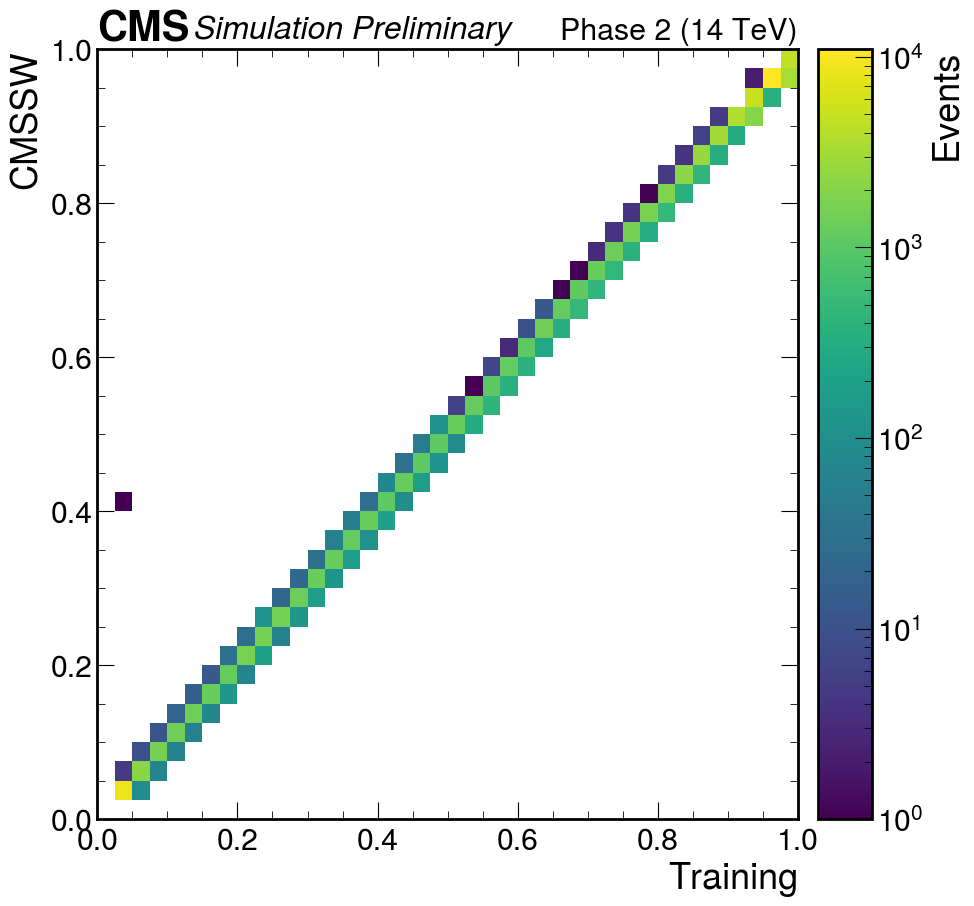

In [12]:
hh = hist.new.Reg(40, 0, 1, name='NNTF', label='Training') \
        .Reg(40, 0, 1, name='CMSSW', label='CMSSW').Weight().fill(ak.to_numpy(ak.flatten(ar['NNTF'])), ar['chargedIso']);
arts, cbar, _ = hh.plot(norm=matplotlib.colors.LogNorm())
cbar.set_label("Events")
hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)", fontsize=23)


/home/anovak/software/micromamba/envs/def/lib/python3.11/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


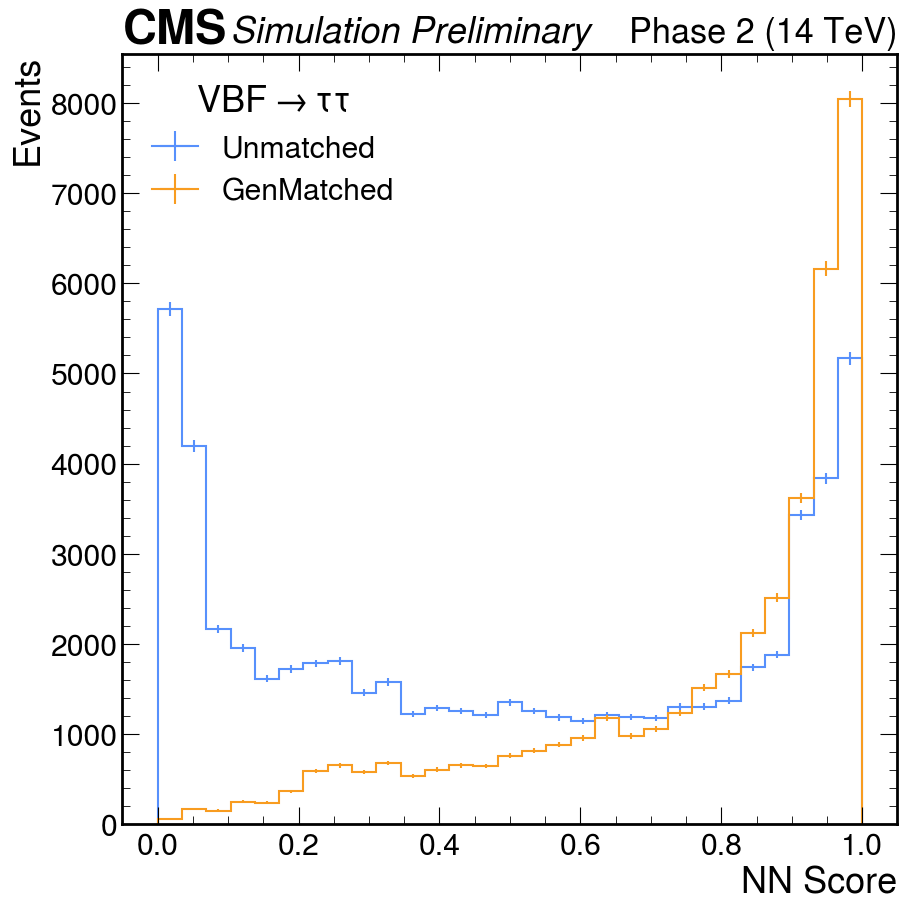

In [13]:
hh = hist.new.Var(np.linspace(0, 1, 30), name='nn', label='NN Score')\
        .StrCat(["Unmatched", "GenMatched"], name='sample', label='Sample').Weight()
                                                            
hh.fill(nnscore[tau_truth], "GenMatched")
hh.fill(nnscore[~tau_truth], "Unmatched")
hh.plot()
hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")
plt.legend(title=r"VBF$\rightarrow\tau\tau$")
plt.ylabel("Events");

# pT Checks

/home/anovak/mplhep/src/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


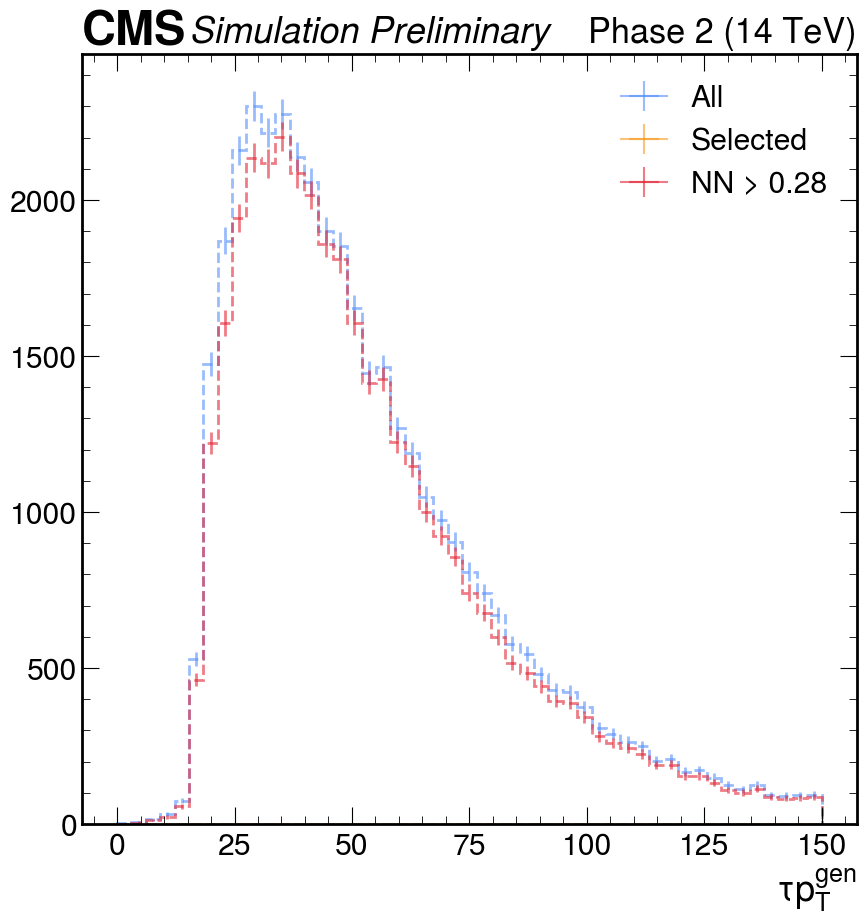

In [115]:
mask = (ar['genpt1'] > 1)
mar = ar[mask]
hpt = hist.new.Var(np.linspace(0, 150, 50), label=r'$\tau p_T^{gen}$').StrCat(["All", "Selected"], growth=True).Weight()
hpt.fill(mar['genpt1'], "All")
hpt.fill(mar['genpt1'][mar['chargedIso'] > 1], "Selected")
hpt.fill(mar['genpt1'][mar['chargedIso'] > 0.28], "NN > 0.28")
hpt.plot(flow='none', ls='--', lw=2, alpha=0.6)
plt.legend()
hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")
plt.xlabel=r'$\tau p_T^{gen}$'

/home/anovak/mplhep/src/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


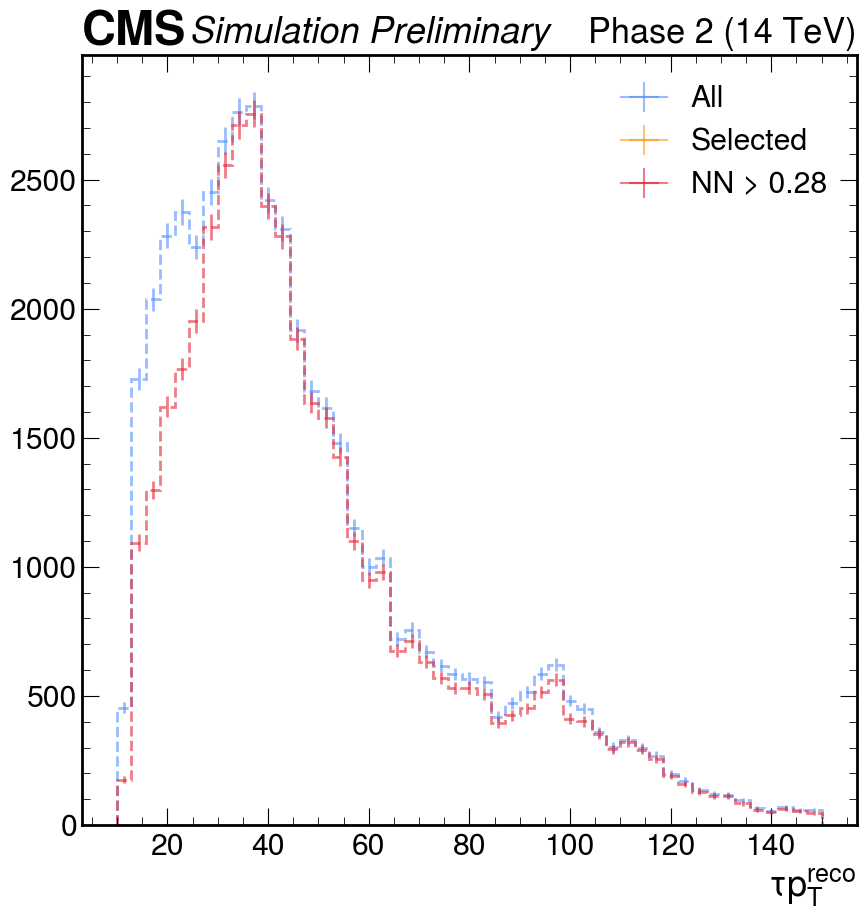

In [127]:
mask = (ar['genpt1'] > 1)
mar = ar[mask]
hpt = hist.new.Var(np.linspace(10, 150, 50), label=r'$\tau p_T^{reco}$').StrCat(["All", "Selected"], growth=True).Weight()
hpt.fill(mar['pt'], "All")
hpt.fill(mar['pt'][mar['chargedIso'] > 1], "Selected")
hpt.fill(mar['pt'][mar['chargedIso'] > 0.28], "NN > 0.28")
hpt.plot(flow='none', ls='--', lw=2, alpha=0.6)
plt.legend()
hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")
plt.xlabel=r'$\tau p_T$'

# Resolution Slices

### DecayId Slices

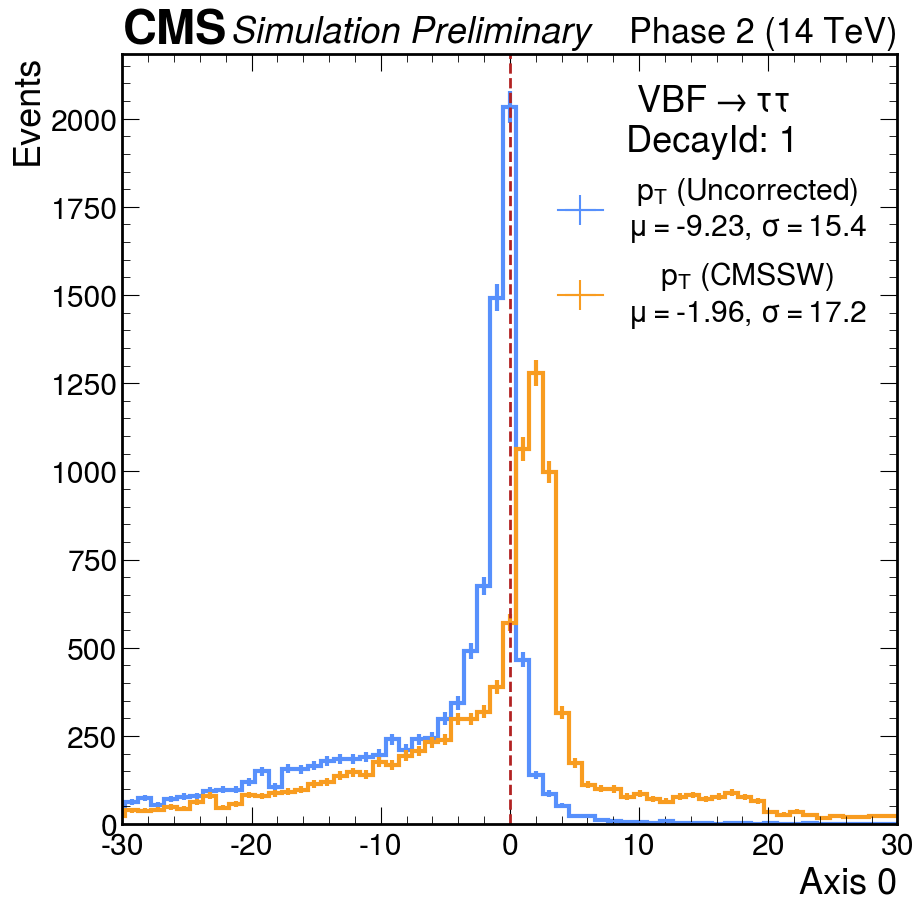

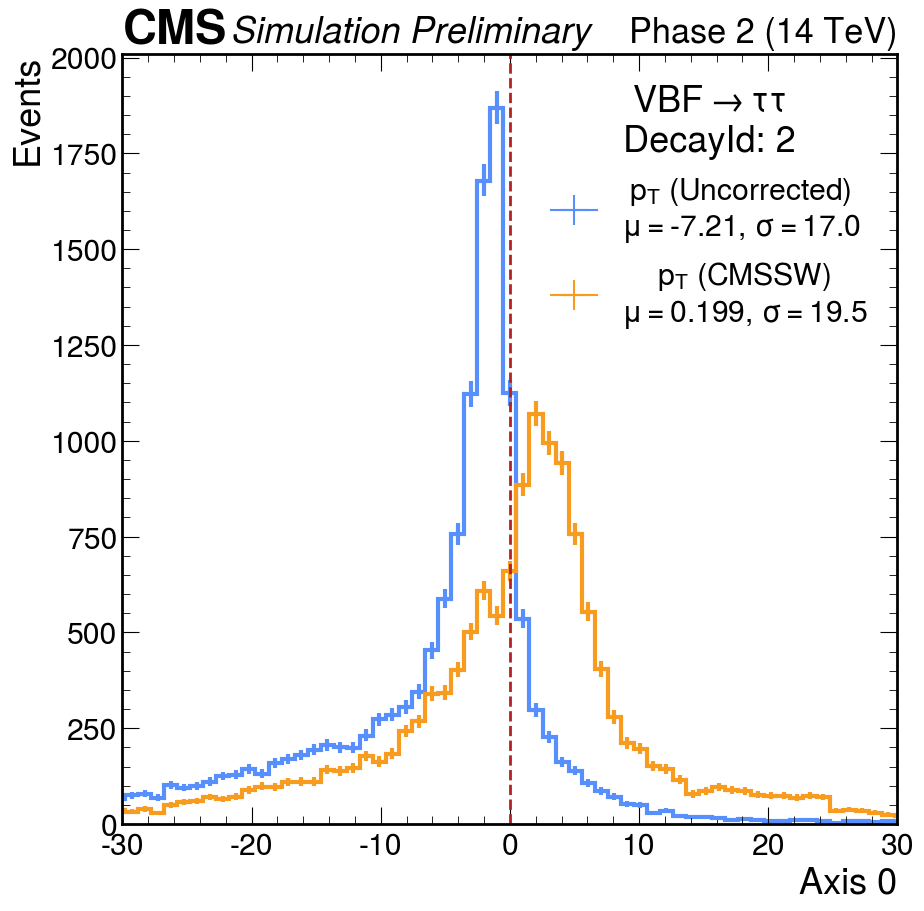

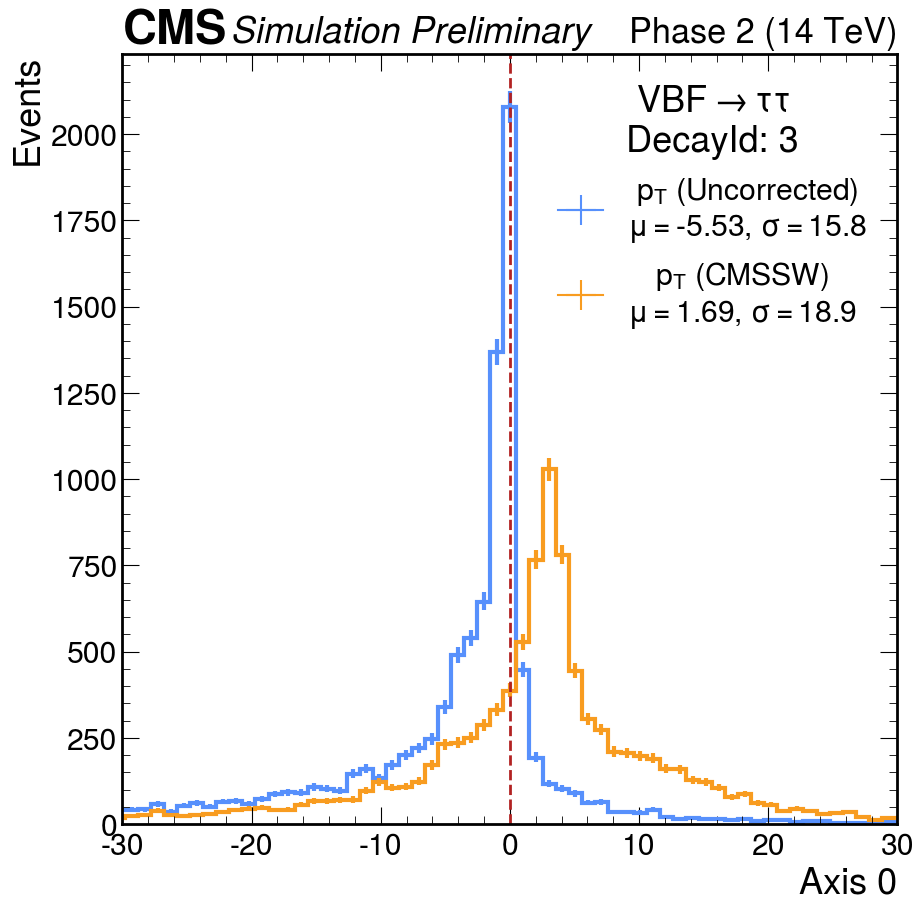

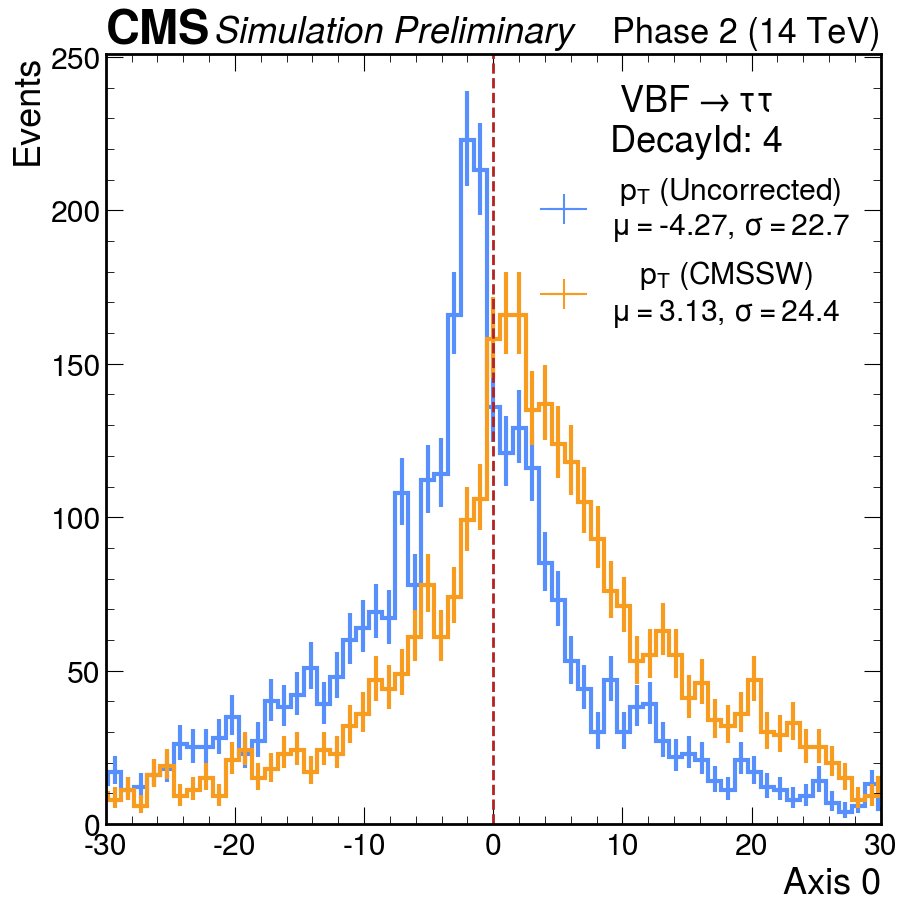

In [114]:
nbins = 100
def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

for decayId in np.unique(ar.decayId):
    tar = ar[ar.decayId == decayId]
    if len(tar) < 10000:
        continue
    fig, ax = plt.subplots()
    hres = hist.new.Var(np.linspace(-50, 50, nbins)).Weight()
    # res = (ar['pt']*ak.flatten(ar['nnptmult']))[ar['genpt1'] > 0] - ar['genpt1'][ar['genpt1'] > 0]
    res = (tar['pt']/ak.flatten(tar['nnptmult']))[tar['genpt1'] > 0] - tar['genpt1'][tar['genpt1'] > 0]
    # print(decayId, np.mean(res), np.std(res))
    hres.fill(res)
    # arts = hres.plot(label=[r"$p_T$ (CMSSW)/corr"], flow='none', lw=3)
    arts = hres.plot(label=[r"$p_T$ (Uncorrected)"+"\n"+f"$\mu =${np.mean(res):.3}, $\sigma=${np.std(res):.3}"], flow='none', lw=3)
    
    hres2 = hist.new.Var(np.linspace(-50, 50, nbins)).Weight()
    res2 = tar['pt'][tar['genpt1'] > 0] - tar['genpt1'][tar['genpt1'] > 0]
    hres2.fill(res2)
    # hres2.plot(label=[r"$p_T$ (CMSSW)"], flow='none', lw=3)
    arts = hres2.plot(label=[r"$p_T$ (CMSSW)"+"\n"+f"$\mu =${np.mean(res2):.3}, $\sigma=${np.std(res2):.3}"], flow='none', lw=3)
    
    plt.axvline(0, color='firebrick', lw=2, ls='--')
    leg = plt.legend(title=r"VBF$\rightarrow\tau\tau$"+"\n"+f"DecayId: {decayId:.0f}", loc=1)
    for t in leg.texts:
        t.set_multialignment('center')
    leg.get_title().set_multialignment('center')    
    hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")
    # plt.xlabel(r"$p_T - p_T^{gen}$")
    plt.ylabel("Events")
    plt.xlim(-30, 30);
    # break

### pT Slices

-6.27691206310808 11.623034875660151
-8.662510702054794 16.315862687722596
-6.712582999884018 21.189995035034414
-6.339208164909947 20.687455982766142
-8.748399994338769 27.87005951538863


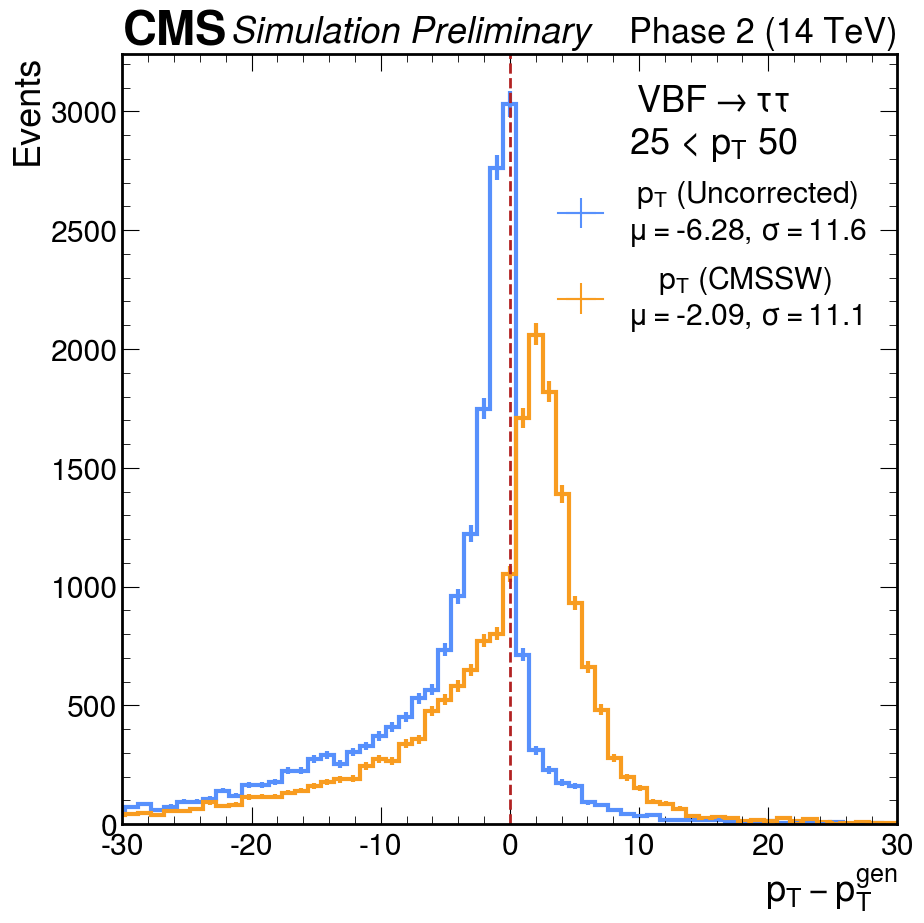

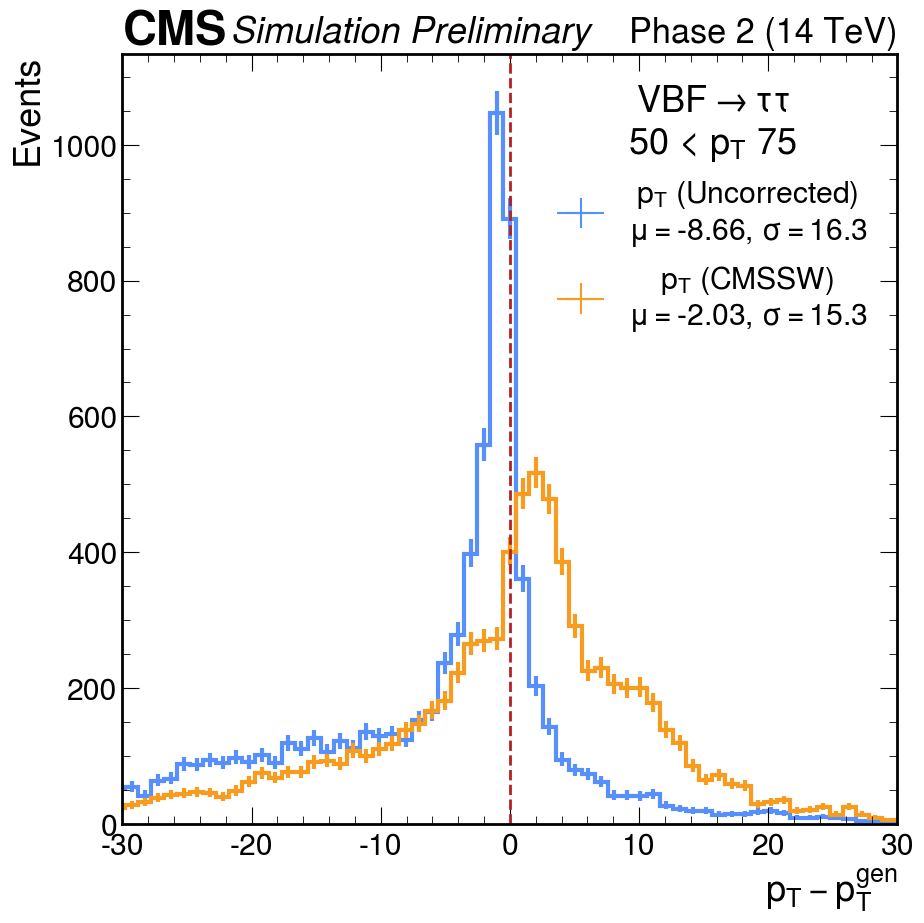

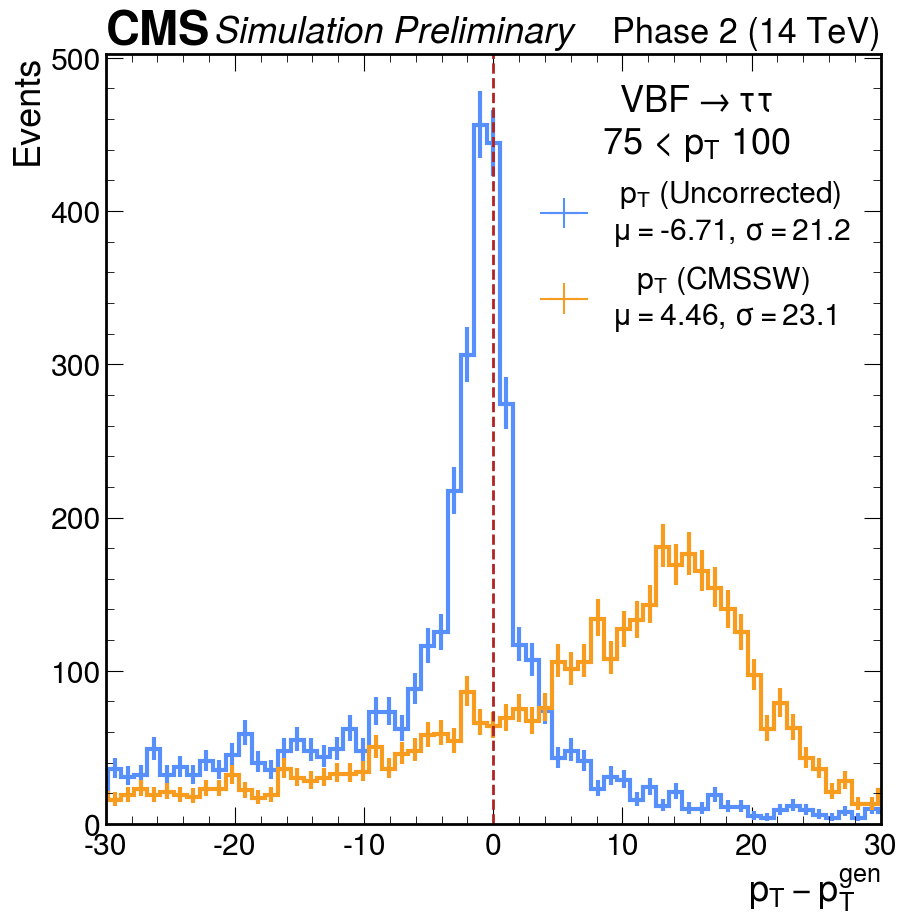

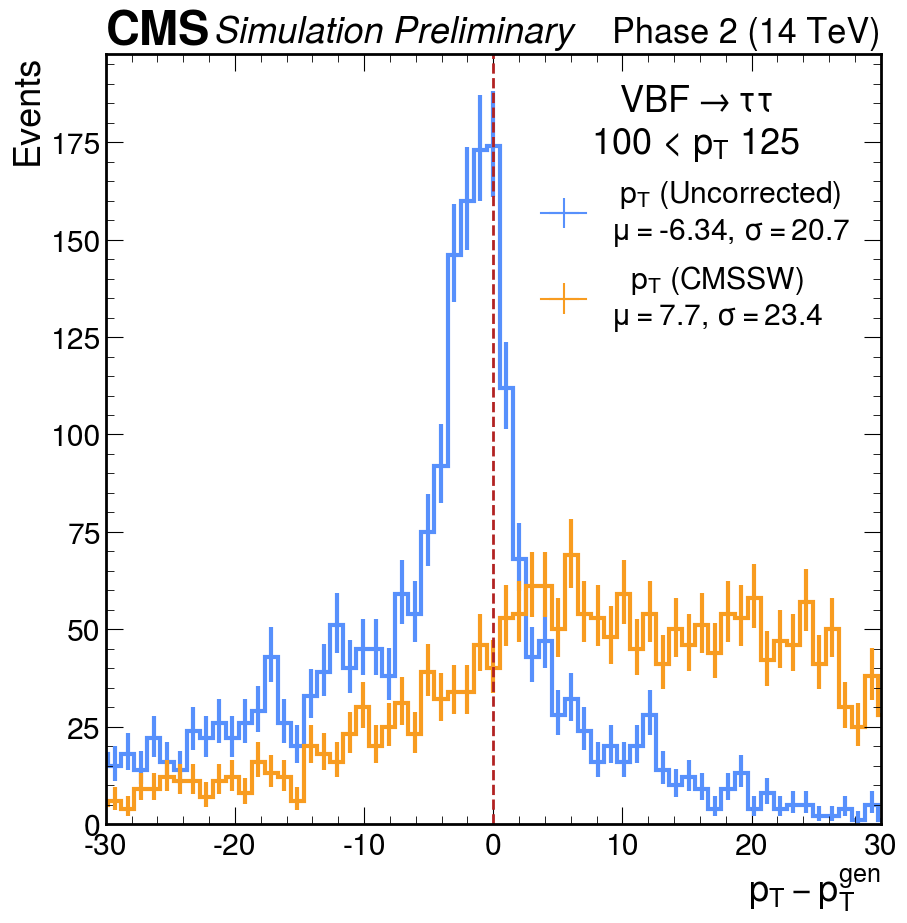

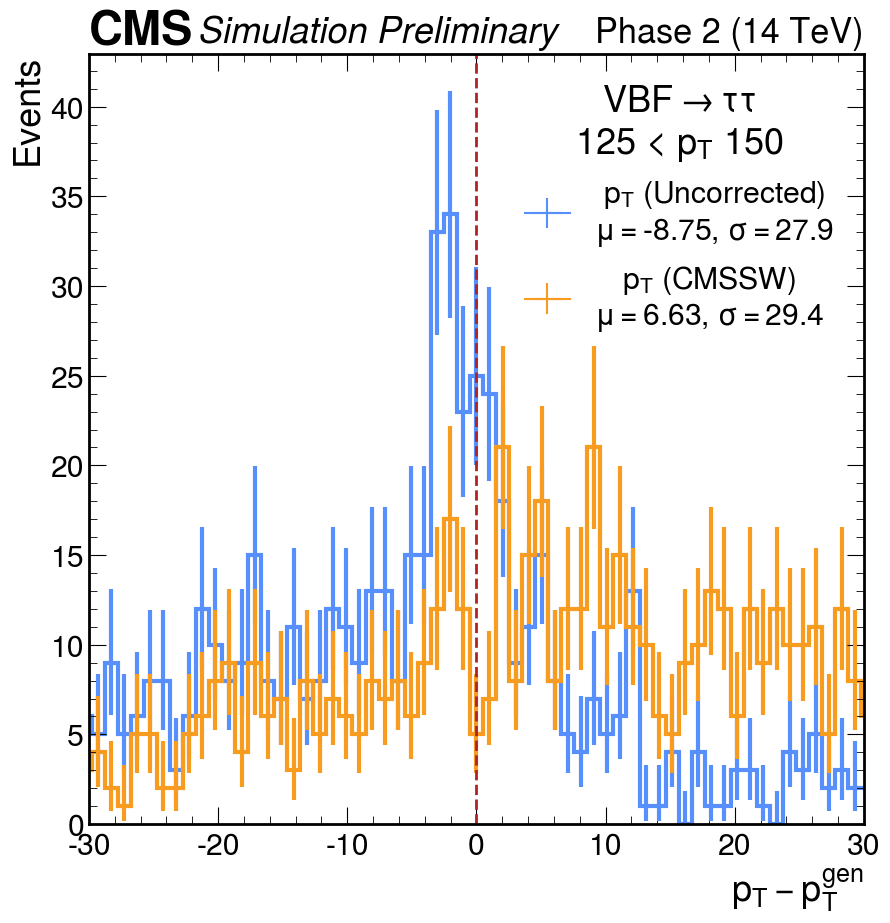

In [56]:
nbins = 100
def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

a = np.arange(25, 170, 25)
btuples = sorted(list(zip(a[::2], a[1::2])) + list(zip(a[1::2], a[2::2])))

for plow, phigh in btuples:
    tar = ar[(ar.pt > plow) & (ar.pt < phigh)]
    # if len(tar) < 1000:
    #     continue
    fig, ax = plt.subplots()
    hres = hist.new.Var(np.linspace(-50, 50, nbins)).Weight()
    # res = (ar['pt']*ak.flatten(ar['nnptmult']))[ar['genpt1'] > 0] - ar['genpt1'][ar['genpt1'] > 0]
    res = (tar['pt']/ak.flatten(tar['nnptmult']))[tar['genpt1'] > 0] - tar['genpt1'][tar['genpt1'] > 0]
    print(np.mean(res), np.std(res))
    hres.fill(res)
    # arts = hres.plot(label=[r"$p_T$ (CMSSW)/corr"], flow='none', lw=3)
    arts = hres.plot(label=[r"$p_T$ (Uncorrected)"+"\n"+f"$\mu =${np.mean(res):.3}, $\sigma=${np.std(res):.3}"], flow='none', lw=3)
    
    hres2 = hist.new.Var(np.linspace(-50, 50, nbins)).Weight()
    res2 = tar['pt'][tar['genpt1'] > 0] - tar['genpt1'][tar['genpt1'] > 0]
    hres2.fill(res2)
    # hres2.plot(label=[r"$p_T$ (CMSSW)"], flow='none', lw=3)
    arts = hres2.plot(label=[r"$p_T$ (CMSSW)"+"\n"+f"$\mu =${np.mean(res2):.3}, $\sigma=${np.std(res2):.3}"], flow='none', lw=3)
    
    plt.axvline(0, color='firebrick', lw=2, ls='--')
    leg = plt.legend(title=r"VBF$\rightarrow\tau\tau$"+"\n"+f"{plow:.0f} < $p_T$ {phigh}", loc=1)
    for t in leg.texts:
        t.set_multialignment('center')
    leg.get_title().set_multialignment('center')    
    hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")
    plt.xlabel(r"$p_T - p_T^{gen}$")
    ax.set_ylabel("Events")
    ax.set_xlim(-30, 30);
    # break

### pT Slices, decayId split

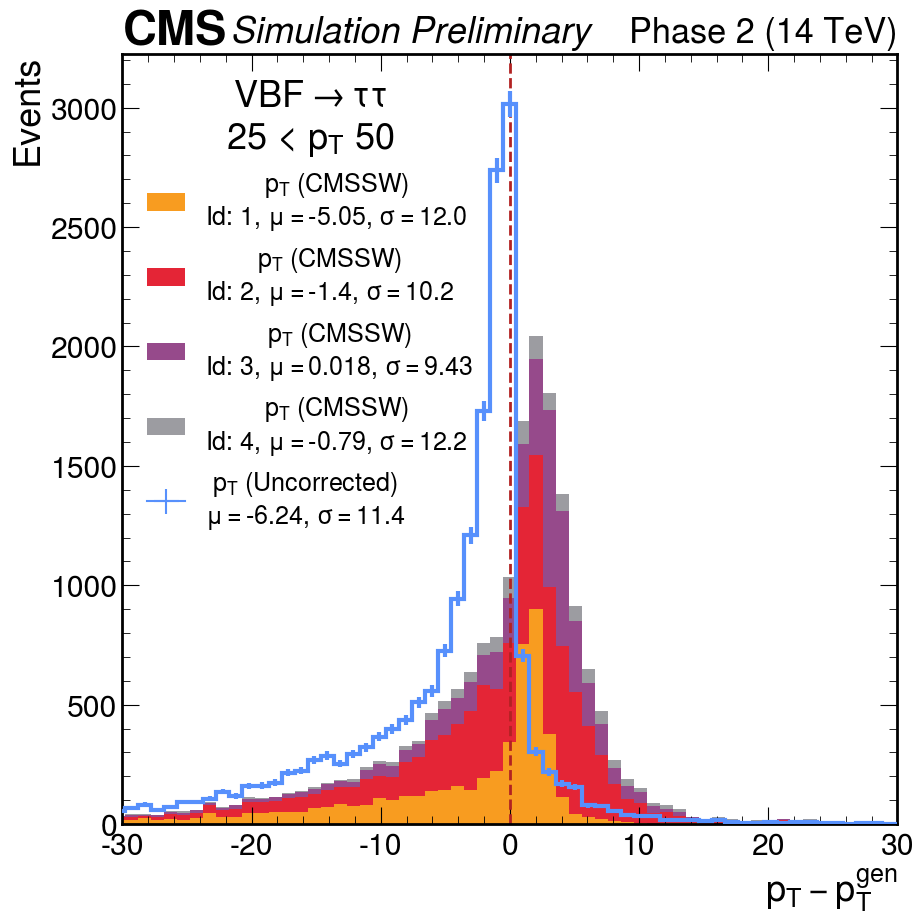

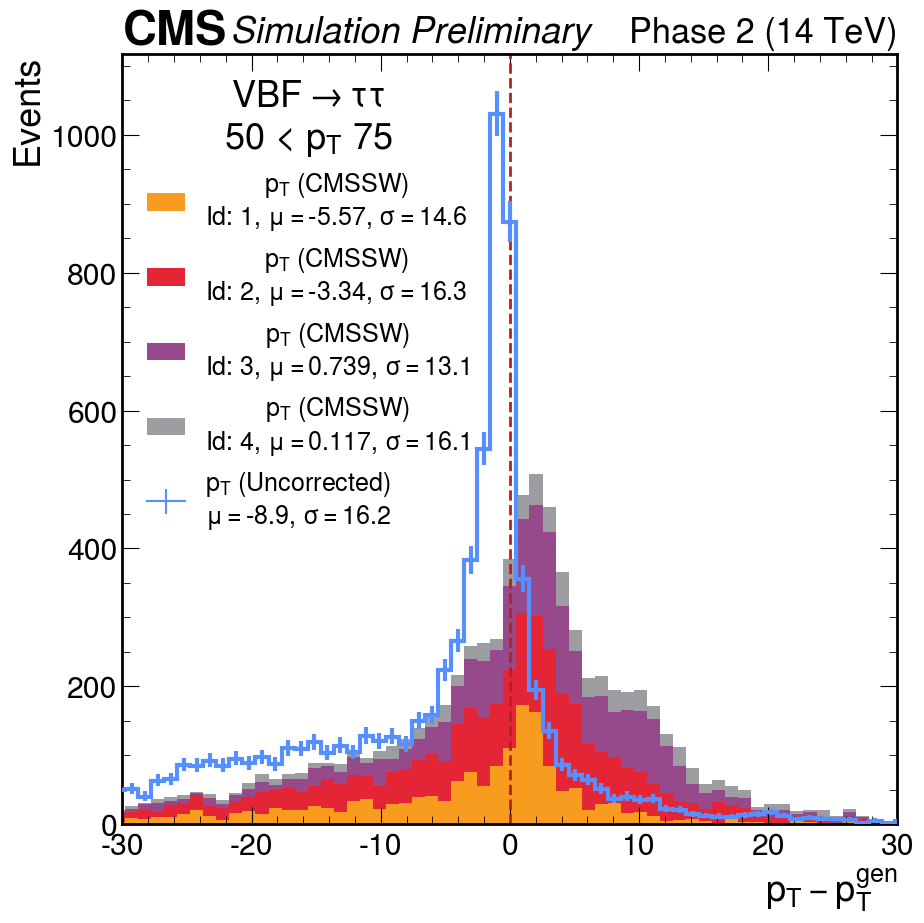

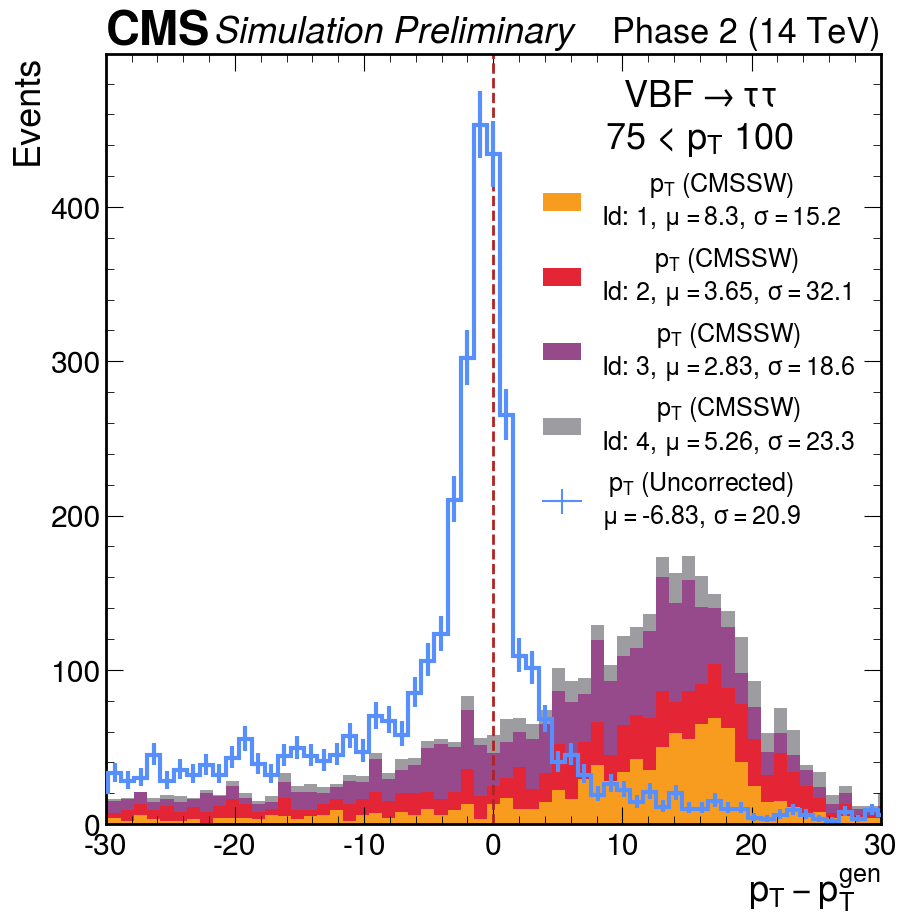

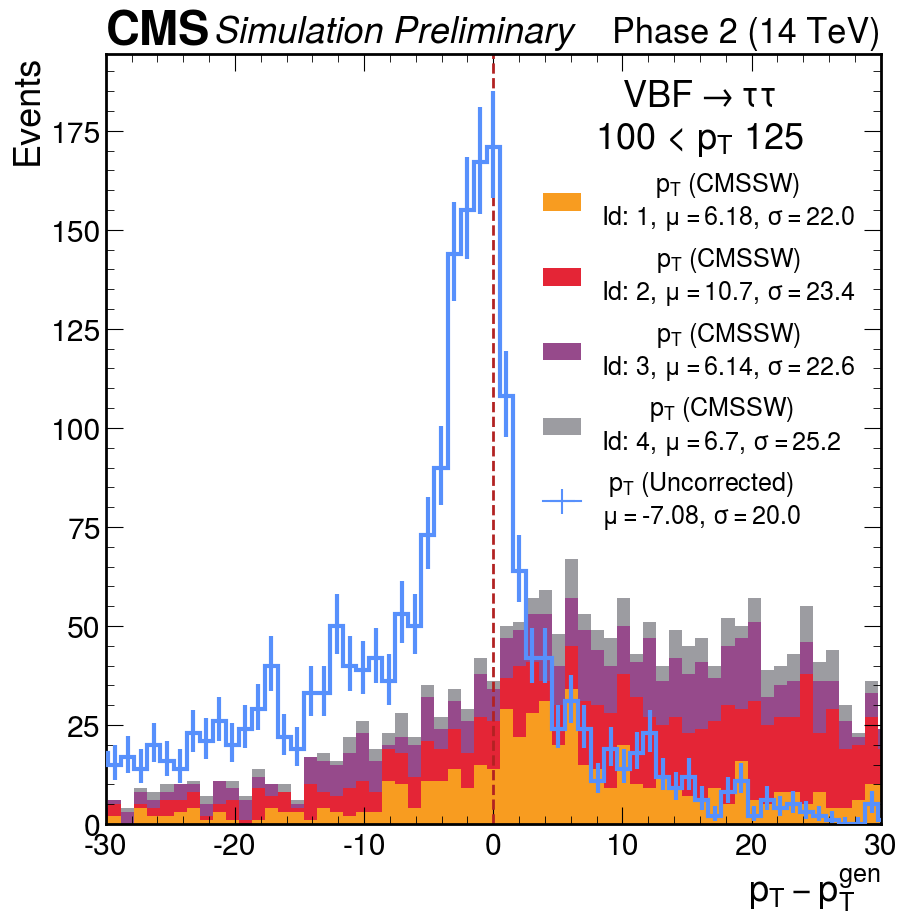

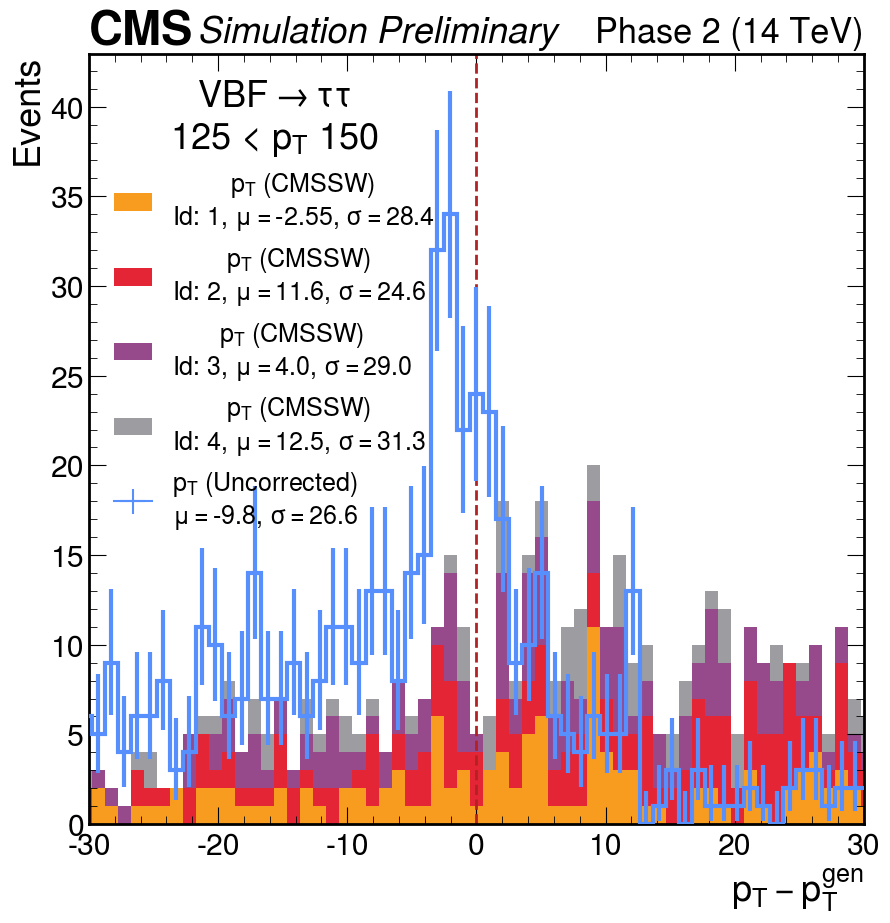

In [113]:
nbins = 100
def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

a = np.arange(25, 170, 25)
btuples = sorted(list(zip(a[::2], a[1::2])) + list(zip(a[1::2], a[2::2])))

for plow, phigh in btuples:
    tar = ar[(ar.pt > plow) & (ar.pt < phigh) & (ar.decayId < 5) & (ar.genpt1 > 0)]
    # if len(tar) < 1000:
    #     continue
    fig, ax = plt.subplots()
    hres = hist.new.Var(np.linspace(-50, 50, nbins)).Weight()
    # res = (ar['pt']*ak.flatten(ar['nnptmult']))[ar['genpt1'] > 0] - ar['genpt1'][ar['genpt1'] > 0]
    res = (tar['pt']/ak.flatten(tar['nnptmult'])) - tar['genpt1']
    # print(np.mean(res), np.std(res))
    # print(len(res), len(tar))
    hres.fill(res)
    # arts = hres.plot(label=[r"$p_T$ (CMSSW)/corr"], flow='none', lw=3)
    arts = hres.plot1d(label=[r"$p_T$ (Uncorrected)"+"\n"+f"$\mu =${np.mean(res):.3}, $\sigma=${np.std(res):.3}"], flow='none', lw=3, zorder=5)
    # arts = hres.plot1d(flow='none', lw=3)
    
    hres2 = hist.new.Var(np.linspace(-50, 50, nbins)).IntCat([1,2,3,4]).Weight()
    res2 = tar['pt'] - tar['genpt1']
    hres2.fill(res2, tar.decayId)
    mustds = [(np.mean(res2[tar.decayId==i]), np.std(res2[tar.decayId==i])) for i in [1,2,3,4]]
    # hres2.plot(label=[r"$p_T$ (CMSSW)"], flow='none', lw=3)
    # arts = hres2.plot(label=[r"$p_T$ (CMSSW)"+"\n"+f"$\mu =${np.mean(res2):.3}, $\sigma=${np.std(res2):.3}"], flow='none', lw=3)
    labels = [r"$p_T$ (CMSSW)"+"\n"+f"Id: {dId}, $\mu =${mustds[dId-1][0]:.3}, $\sigma=${mustds[dId-1][1]:.3}" for dId in [1,2,3,4]]
    # arts = hres2.plot(flow='none', lw=3)
    hep.histplot([hres2[:, i] for i in range(0,4)], stack=True, histtype='fill', zorder=-5, label=labels, flow='none')
    
    plt.axvline(0, color='firebrick', lw=2, ls='--')
    leg = plt.legend(title=r"VBF$\rightarrow\tau\tau$"+"\n"+f"{plow:.0f} < $p_T$ {phigh}", loc='best', fontsize='x-small')
    for t in leg.texts:
        t.set_multialignment('center')
    leg.get_title().set_multialignment('center')    
    hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")
    plt.xlabel(r"$p_T - p_T^{gen}$")
    ax.set_ylabel("Events")
    ax.set_xlim(-30, 30);
    # break

## Efficiencies

In [123]:
ar = trees.arrays()
ar = ak.with_field(ar, pred[0], where='NNTF')
ar = ak.with_field(ar, pred[1], where='nnptmult')

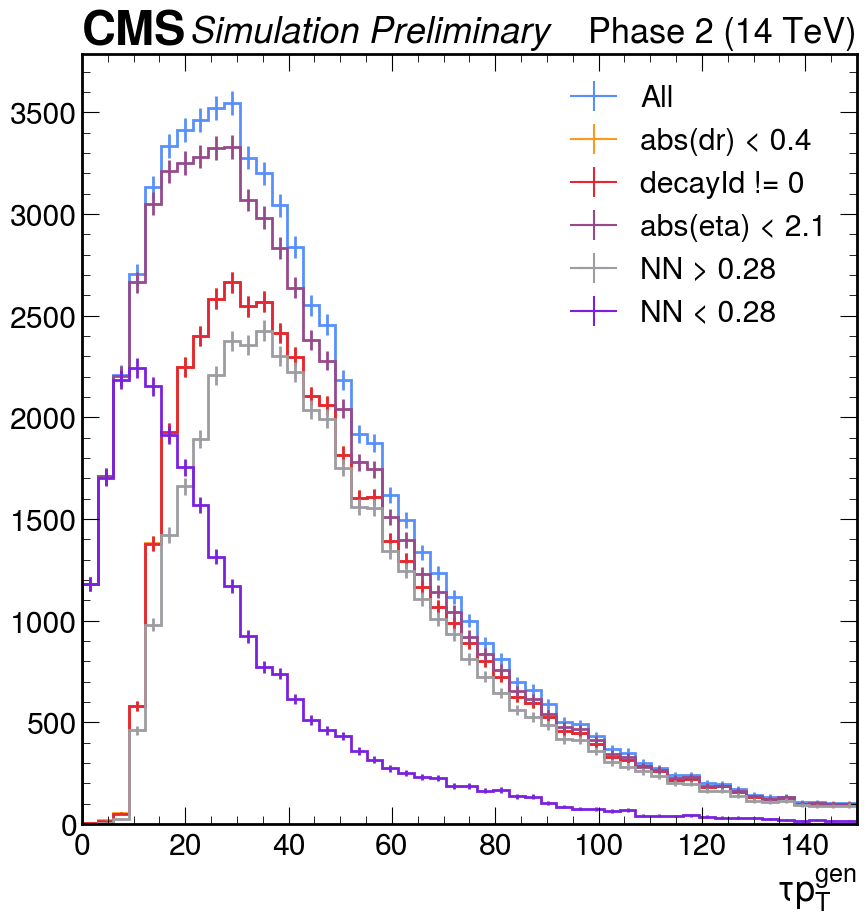

In [124]:
hpt = hist.new.Var(np.linspace(0, 150, 50), label=r'$\tau p_T^{gen}$').StrCat([], growth=True).Weight()

overall_sel = (ar['genpt1'] > 0)
tar = ar[overall_sel]
hpt.fill(tar['genpt1'], "All")
hpt.fill(tar['genpt1'][abs(tar['gendr1']) < 0.4], "abs(dr) < 0.4")
hpt.fill(tar['genpt1'][tar['decayId'] > 0], "decayId != 0")
hpt.fill(tar['genpt1'][abs(tar['eta']) < 2.1], "abs(eta) < 2.1")
hpt.fill(tar['genpt1'][tar['chargedIso'] > 0.28], "NN > 0.28")
hpt.fill(tar['genpt1'][tar['chargedIso'] < 0.28], "NN < 0.28")
hpt.plot(flow='none', lw=2)
plt.legend()
plt.xlim(0, 150)
hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")
plt.gca().set_xlabel=r'$\tau p_T^{gen}$'

# Efficiency plots

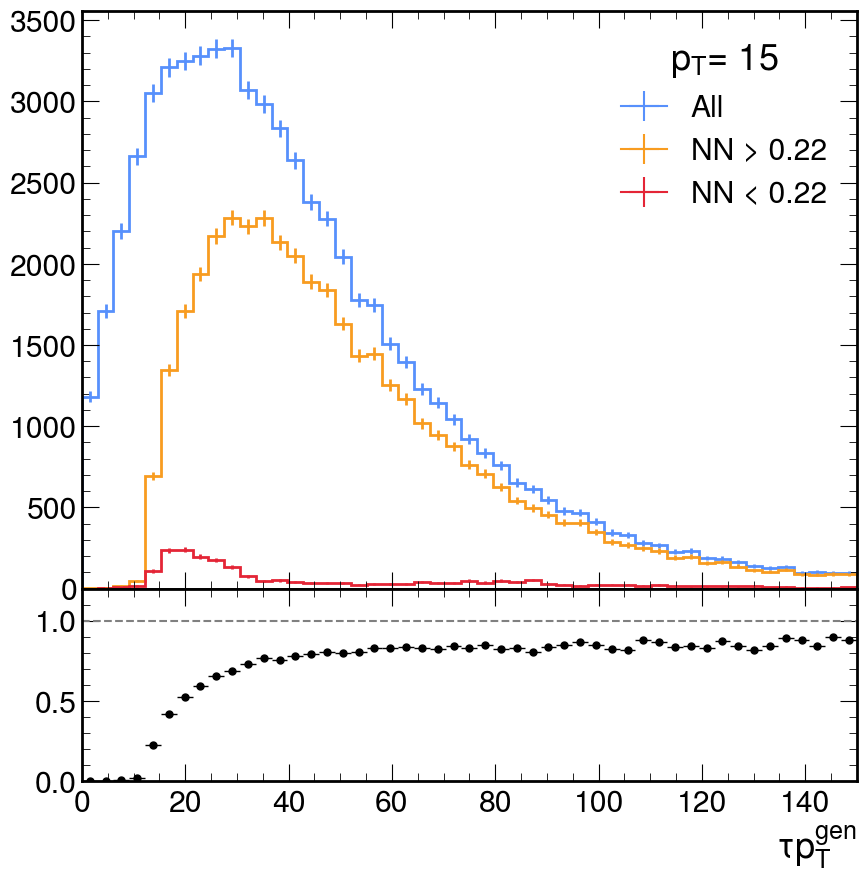

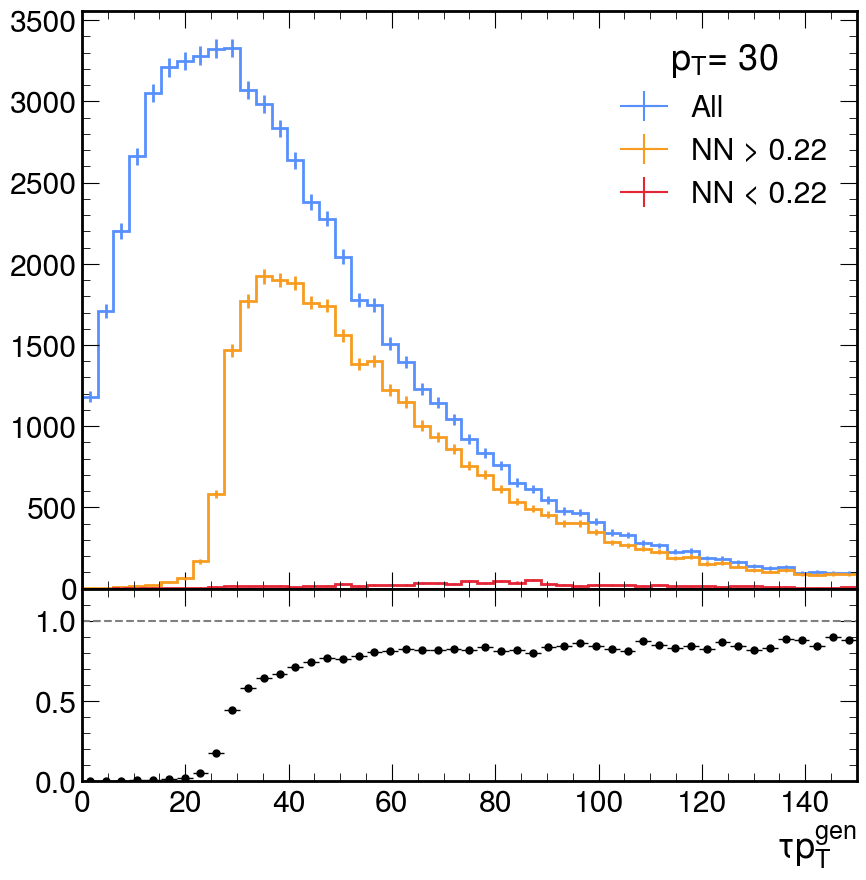

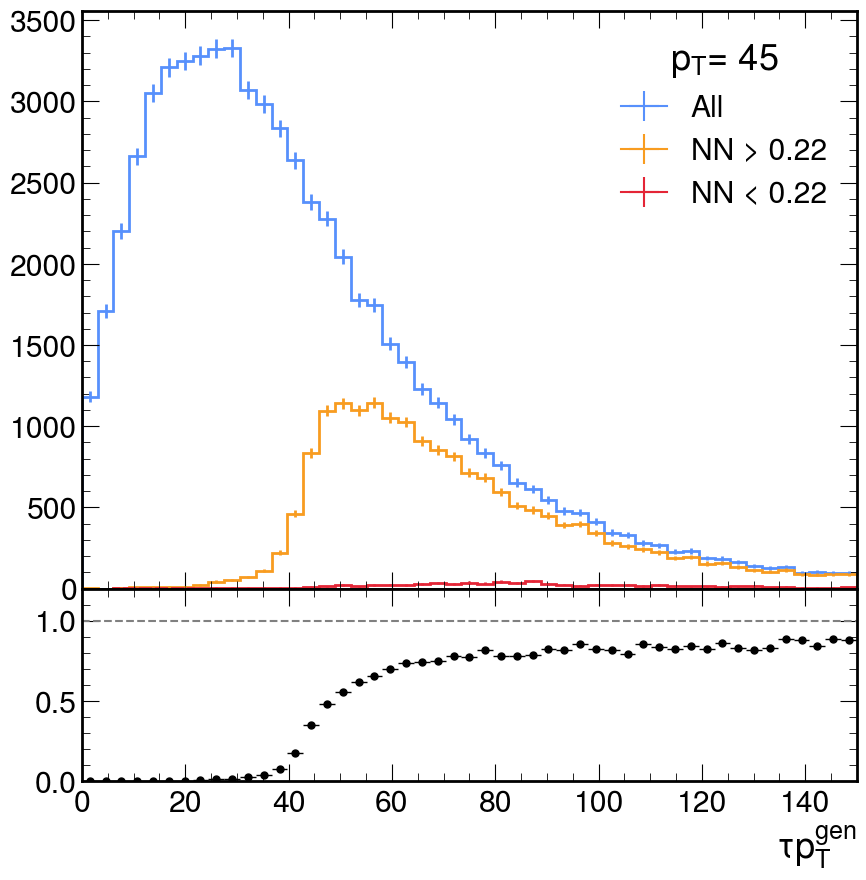

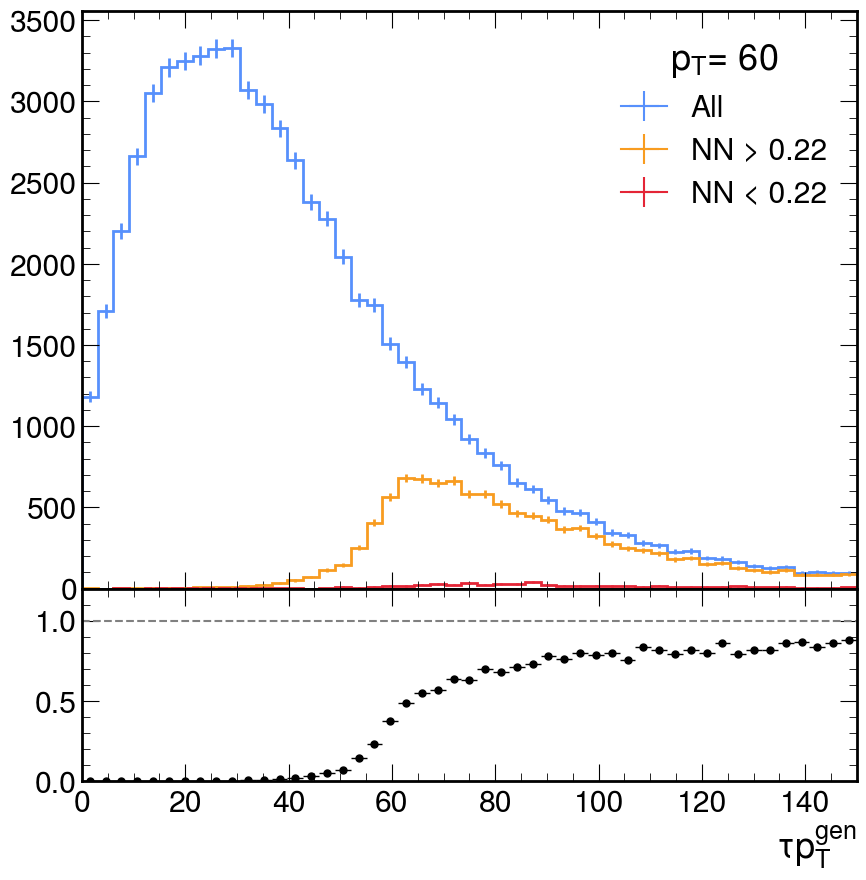

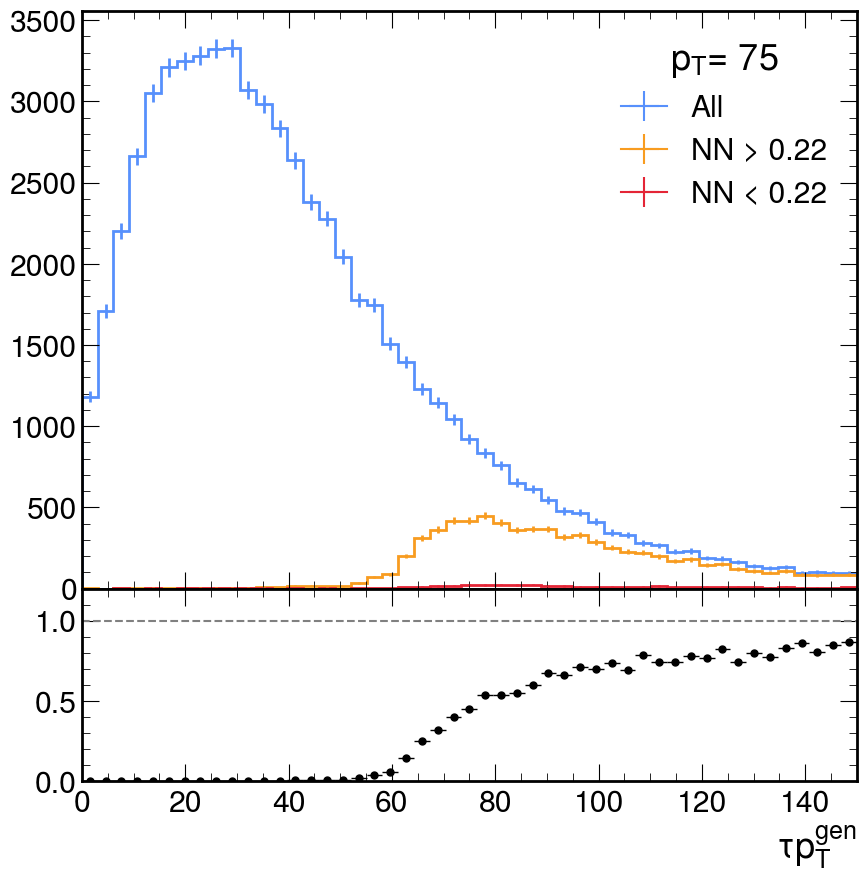

In [41]:
def eff_plot(pt, plot=False):
    cut = 0.22
    overall_sel = (ar['genpt1'] > 0) & (abs(ar['eta']) < 2.1)
    tar = ar[overall_sel]
    tagged_sel = (tar['chargedIso'] > cut) & (abs(tar['gendr1']) < 0.4)  & (tar['pt'] > pt)
    untagged_sel = (tar['chargedIso'] < cut) & (abs(tar['gendr1']) < 0.4)  & (tar['pt'] > pt)
    
    hpt = hist.new.Var(np.linspace(0, 150, 50), label=r'$\tau p_T^{gen}$').StrCat([], growth=True).Weight()
    
    
    hpt.fill(tar['genpt1'], "All")
    hpt.fill(tar['genpt1'][tagged_sel], f"NN > {cut}")
    hpt.fill(tar['genpt1'][untagged_sel], f"NN < {cut}")
    
    if plot:
        fig, (ax, rax) = plt.subplots(2, 1, sharex=True, height_ratios=[3,1])
        fig.subplots_adjust(hspace=0)
        hpt.plot(flow='none', lw=2, ax=ax)
        ax.legend(title=r'$p_T$'+f'= {pt}')
        ax.set_xlim(0, 150)
        rax.set_xlabel(ax.get_xlabel())
        ax.set_xlabel(None);
    
    
    ratio = hpt[:, f"NN > {cut}"].values()/hpt[:, "All"].values()
    if plot:
        rax.set_ylim(0, 1.2)
        hep.histplot(ratio, hpt.axes[0].edges, histtype='errorbar', ax=rax, yerr=False, xerr=True, color='k')
        rax.axhline(1, color='gray', ls='--')
    return ratio, hpt.axes[0].centers

effs = {}
for pt in [0, *np.arange(15, 80, 5)]:
    # plot = False
    plot = True if pt in np.arange(15, 80, 5)[::3] else False
    eff, centers = eff_plot(pt, plot=plot)
    effs[pt] = eff

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

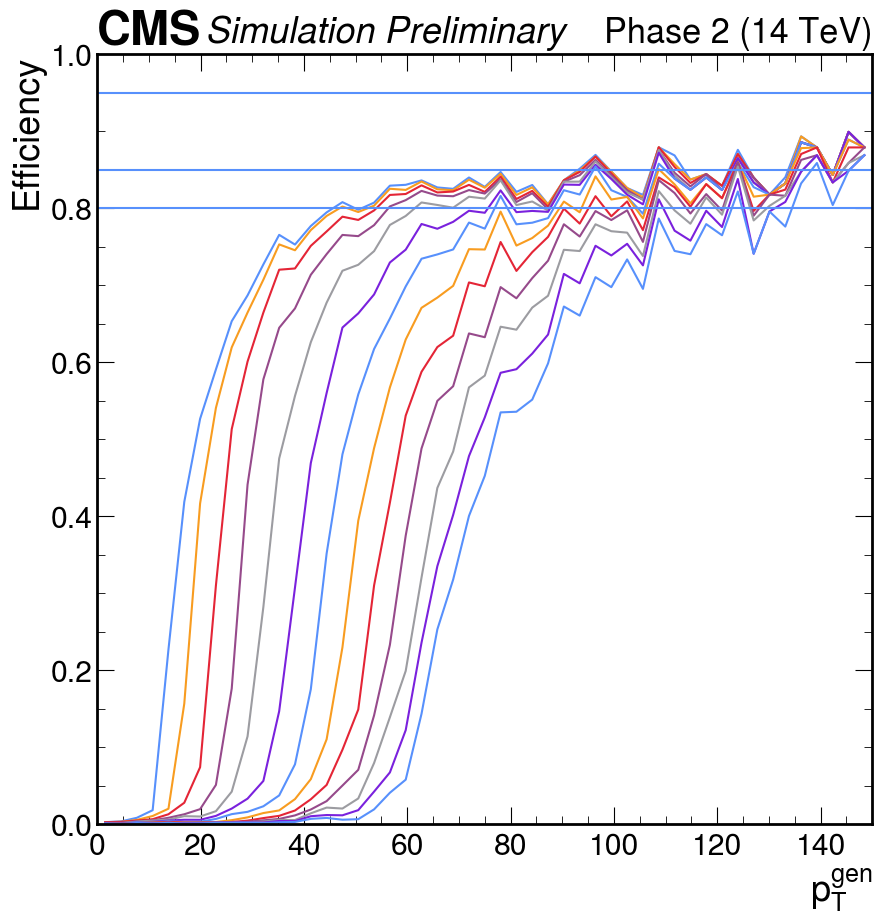

In [46]:
fig, ax = plt.subplots()
for pt in sorted(effs.keys())[1:]:
    ax.plot(centers, effs[pt])
ax.axhline(0.95)
ax.axhline(0.85)
ax.axhline(0.80)
ax.set_xlim(0,150)
ax.set_ylim(0,1)
ax.set_xlabel(r"$p_T^{gen}$")
ax.set_ylabel(r"Efficiency")
hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

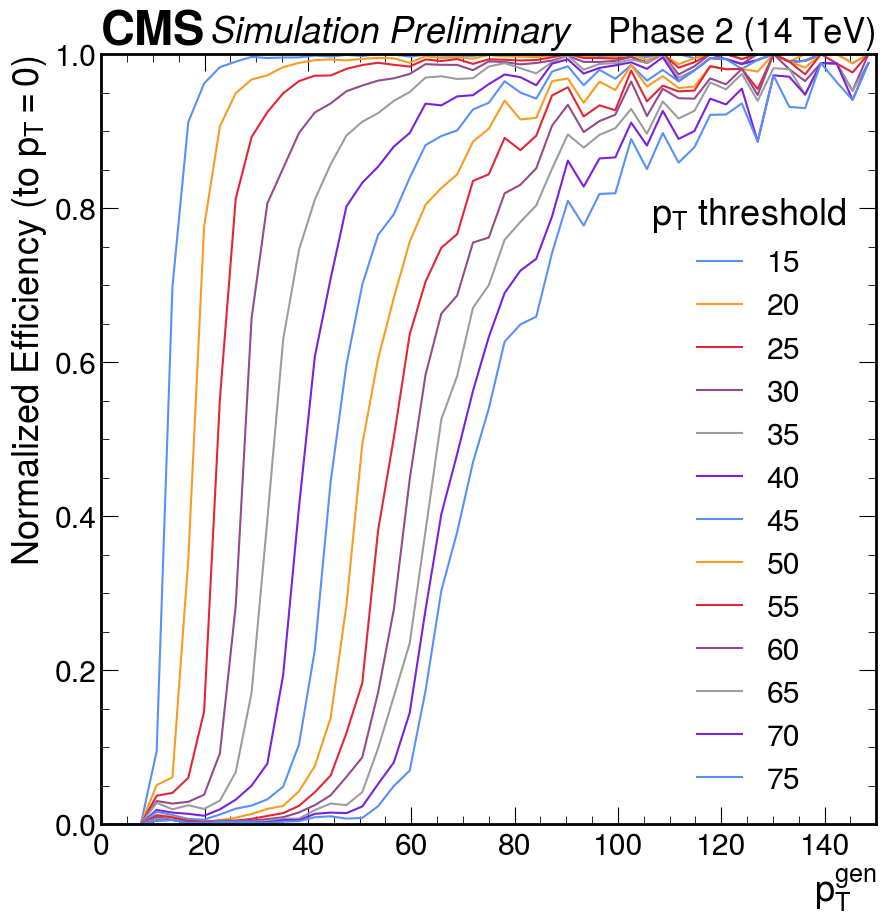

In [27]:
ths = []
fig, ax = plt.subplots()
for pt in sorted(effs.keys())[1:]:
    a = effs[pt]/effs[0]
    a[:3] = 0 # mask low values
    try:
        ths.append(centers[np.where(a > 0.95)[0][0]])
    except:
        ths.append(1.)
    ax.plot(centers, a, label=pt)
ax.set_xlim(0,150)
ax.set_ylim(0,1)
ax.set_xlabel(r"$p_T^{gen}$")
ax.set_ylabel(r"Normalized Efficiency (to $p_T = 0$)")
ax.legend(title=r"$p_T$ threshold")
hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

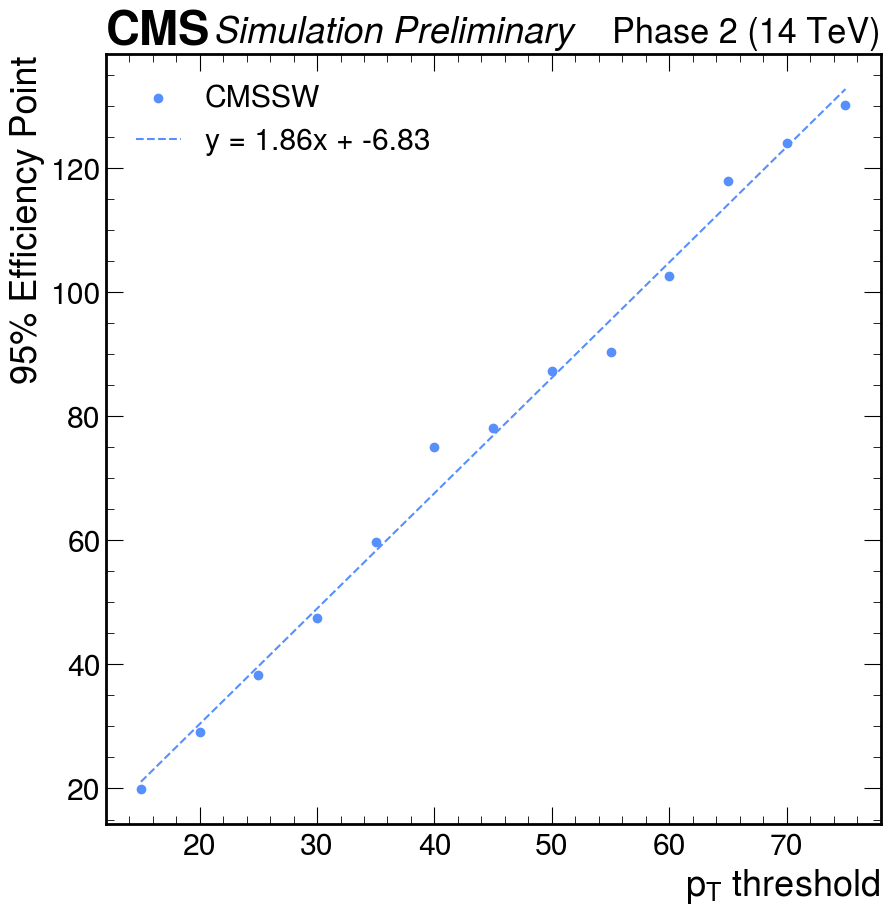

In [28]:
fig, ax = plt.subplots()
x, y = sorted(effs.keys())[1:], ths
ax.scatter(x, y, label="CMSSW")

coef = np.polyfit(x, y,1)
poly1d_fn = np.poly1d(coef) 
ax.plot(x, poly1d_fn(x), '--', label=f'y = {coef[0]:.2f}x + {coef[1]:.2f}')

# ax.set_xlim(0,80)
# ax.set_ylim(0,150)
ax.set_xlabel(r"$p_T$ threshold")
ax.set_ylabel(r"95% Efficiency Point")
ax.legend()
hep.cms.label("Preliminary", rlabel="Phase 2 (14 TeV)")